In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'wlcstat-master')))

import wlcstat.chromo

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'stochastic-gene-conf-master')))

figure_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'subfigures/'))
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data/'))

from stochastic_gene_conf import gene_conf
from stochastic_gene_conf import gene_analysis

import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
import pickle
import warnings #for sparse runs to minimize console output
import pandas as pd

In [6]:
warnings.filterwarnings('ignore')

alpha = 250 # +- genomic distance
filter_width = 25000 #SG smoothing filter width
window = 5000 #+- region of TSS to exclude from analysis
val = 16001 #number of points for coarse grained signal
delta = 10 #peak tolerance to evaluate pvalue

val1_combined = pd.DataFrame()
val2_combined = pd.DataFrame()

for model in ['poisson','regular','uniform']:
    
    print('Testing model: '+model)
    
    with open(data_path+'4C_params.pkl', 'rb') as file:
        temp = pickle.load(file)
        df_4C = temp[0]
        df_x = temp[1]
        df_hypervals_4C = temp[2]
        val = temp[3]

    with open(data_path+'ATACEM_'+model+'_params.pkl', 'rb') as file:
        temp = pickle.load(file)
        df_aapoly = temp[0]
        df_x = temp[1]
        df_hypervals_aapoly = temp[2] #Key format (4C training gene, time point, eval gene, +- genomic distance)
        val = temp[3]
        
    with open(data_path+'ATACEM_'+model+'_pvals.pkl', 'rb') as file:
        temp = pickle.load(file)
        M = temp[0]
        df_pvals_0hr = temp[1]
        df_pvals_1hr = temp[2]
        df_metric_0hr = temp[3]
        df_metric_1hr = temp[4]
        df_mc_vec_0hr = temp[5]
        df_mc_vec_1hr = temp[6]
        alpha_vec = temp[7]
        
    print("Collecting peaks...")
        
    df_peaks_0hr_4C = dict()
    df_peaks_1hr_4C = dict()
    df_peaks_0hr_aapoly = dict()
    df_peaks_1hr_aapoly = dict()

    a = 250
    delta = 10
    for gene_name in ['IL6','CXCL9','CXCL10','IL15']:

        for gt_name in ['CXCL9']:
            if gene_name == 'CXCL10' or gene_name == 'IL15':
                idx = 2
            else:
                idx = 0
            if gene_name == 'IL6' or gene_name == 'CXCL9':
                alpha = 250
            else:
                alpha = 250

            i_left = np.argmin(np.abs(df_x[gene_name]+a))
            i_right = np.argmin(np.abs(df_x[gene_name]-a))

            (valleys_4C_0hr,peaks_4C_0hr) = gene_analysis.define_peaks(np.array(df_4C[gene_name,idx,0])[i_left:i_right],
                                                                       df_hypervals_4C[gt_name,0,alpha][0],
                                                                       df_hypervals_4C[gt_name,0,alpha][1],
                                                                       df_hypervals_4C[gt_name,0,alpha][2],val)
            peaks_4C_0hr = gene_analysis.filter_peaks(np.array(df_x[gene_name][i_left:i_right]),peaks_4C_0hr,window/1000)
            df_peaks_0hr_4C[gene_name,gt_name] = peaks_4C_0hr.astype(int)


            (valleys_4C_1hr,peaks_4C_1hr) = gene_analysis.define_peaks(np.array(df_4C[gene_name,idx,1])[i_left:i_right],
                                                                       df_hypervals_4C[gt_name,0,alpha][0],
                                                                       df_hypervals_4C[gt_name,0,alpha][1],
                                                                       df_hypervals_4C[gt_name,0,alpha][2],val)
            peaks_4C_1hr = gene_analysis.filter_peaks(np.array(df_x[gene_name][i_left:i_right]),peaks_4C_1hr,window/1000)
            df_peaks_1hr_4C[gene_name,gt_name] = peaks_4C_1hr.astype(int)

            (valleys_pred_0hr,peaks_pred_0hr) = gene_analysis.define_peaks(np.array(df_aapoly[gene_name,0])[i_left:i_right],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][0],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][1],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][2],val)
            peaks_pred_0hr = gene_analysis.filter_peaks(np.array(df_x[gene_name][i_left:i_right]),peaks_pred_0hr,window/1000)
            df_peaks_0hr_aapoly[gene_name,gt_name] = peaks_pred_0hr.astype(int)

            (valleys_pred_1hr,peaks_pred_1hr) = gene_analysis.define_peaks(np.array(df_aapoly[gene_name,1])[i_left:i_right],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][0],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][1],
                                                                           df_hypervals_aapoly[gt_name,0,gt_name,alpha][2],val)
            peaks_pred_1hr = gene_analysis.filter_peaks(np.array(df_x[gene_name][i_left:i_right]),peaks_pred_1hr,window/1000)
            df_peaks_1hr_aapoly[gene_name,gt_name] = peaks_pred_1hr.astype(int)

    df_peaks_0hr_4C = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_peaks_0hr_4C.items() ]))
    df_peaks_1hr_4C = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_peaks_1hr_4C.items() ]))
    df_peaks_0hr_aapoly = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_peaks_0hr_aapoly.items() ]))
    df_peaks_1hr_aapoly = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_peaks_1hr_aapoly.items() ]))
    
    print("Computing combined metric...")

    metric_combined = pd.DataFrame()

    for gt_name in ['CXCL9']:

        val1 = 0
        val2 = 0

        denom1 = 0
        denom2 = 0

        for gene_name in ['IL6','CXCL9','CXCL10','IL15']:

            if gene_name != gt_name:

                peaks_pred_0hr = np.array(df_peaks_0hr_aapoly[gene_name,gt_name][~np.isnan(df_peaks_0hr_aapoly[gene_name,gt_name])]).astype(int)
                peaks_4C_0hr = np.array(df_peaks_0hr_4C[gene_name,gt_name][~np.isnan(df_peaks_0hr_4C[gene_name,gt_name])]).astype(int)

                distance_predto4C_0hr = np.zeros(len(peaks_pred_0hr))
                distance_4Ctopred_0hr = np.zeros(len(peaks_4C_0hr))

                for j in range(len(peaks_pred_0hr)):
                    jx = np.argmin(np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_4C_0hr]-np.array(df_x[gene_name][i_left:i_right])[peaks_pred_0hr[j]]))
                    distance_predto4C_0hr[j] = np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_pred_0hr[j]]-np.array(df_x[gene_name][i_left:i_right])[peaks_4C_0hr[jx]])

                for j in range(len(peaks_4C_0hr)):
                    jx = np.argmin(np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_pred_0hr]-np.array(df_x[gene_name][i_left:i_right])[peaks_4C_0hr[j]]))
                    distance_4Ctopred_0hr[j] = np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_4C_0hr[j]]-np.array(df_x[gene_name][i_left:i_right])[peaks_pred_0hr[jx]])

                val1 += sum(distance_predto4C_0hr<=delta)
                denom1 += len(distance_predto4C_0hr)
                val2 += sum(distance_4Ctopred_0hr<=delta)
                denom2 += len(distance_4Ctopred_0hr)

            peaks_pred_1hr = np.array(df_peaks_1hr_aapoly[gene_name,gt_name][~np.isnan(df_peaks_1hr_aapoly[gene_name,gt_name])]).astype(int)
            peaks_4C_1hr = np.array(df_peaks_1hr_4C[gene_name,gt_name][~np.isnan(df_peaks_1hr_4C[gene_name,gt_name])]).astype(int)

            distance_predto4C_1hr = np.zeros(len(peaks_pred_1hr))
            distance_4Ctopred_1hr = np.zeros(len(peaks_4C_1hr))

            for j in range(len(peaks_pred_1hr)):
                jx = np.argmin(np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_4C_1hr]-np.array(df_x[gene_name][i_left:i_right])[peaks_pred_1hr[j]]))
                distance_predto4C_1hr[j] = np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_pred_1hr[j]]-np.array(df_x[gene_name][i_left:i_right])[peaks_4C_1hr[jx]])

            for j in range(len(peaks_4C_1hr)):
                jx = np.argmin(np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_pred_1hr]-np.array(df_x[gene_name][i_left:i_right])[peaks_4C_1hr[j]]))
                distance_4Ctopred_1hr[j] = np.abs(np.array(df_x[gene_name][i_left:i_right])[peaks_4C_1hr[j]]-np.array(df_x[gene_name][i_left:i_right])[peaks_pred_1hr[jx]])

            distance_predto4C_0hr = np.sort(distance_predto4C_0hr)
            distance_4Ctopred_0hr = np.sort(distance_4Ctopred_0hr)

            distance_predto4C_1hr = np.sort(distance_predto4C_1hr)
            distance_4Ctopred_1hr = np.sort(distance_4Ctopred_1hr)

            val1 += sum(distance_predto4C_1hr<=delta)
            denom1 += len(distance_predto4C_1hr)
            val2 += sum(distance_4Ctopred_1hr<=delta)
            denom2 += len(distance_4Ctopred_1hr)

        val1_combined[gt_name,model] = [val1/denom1]
        val2_combined[gt_name,model] = [val2/denom2]

        metric_combined[gt_name] = [np.min([val1_combined[gt_name,model],val2_combined[gt_name,model]])]
        
    print("ACC,1-FDR: ("+str(val1_combined[gt_name,model][0]),", "+str(val2_combined[gt_name,model][0])+")")

Testing model: poisson
Computing combined metric...
ACC,1-FDR: (0.7013888888888888 , 0.7131147540983607)
Testing model: regular
Computing combined metric...
ACC,1-FDR: (0.7096774193548387 , 0.8278688524590164)
Testing model: uniform
Computing combined metric...
ACC,1-FDR: (0.673202614379085 , 0.7868852459016393)


poisson


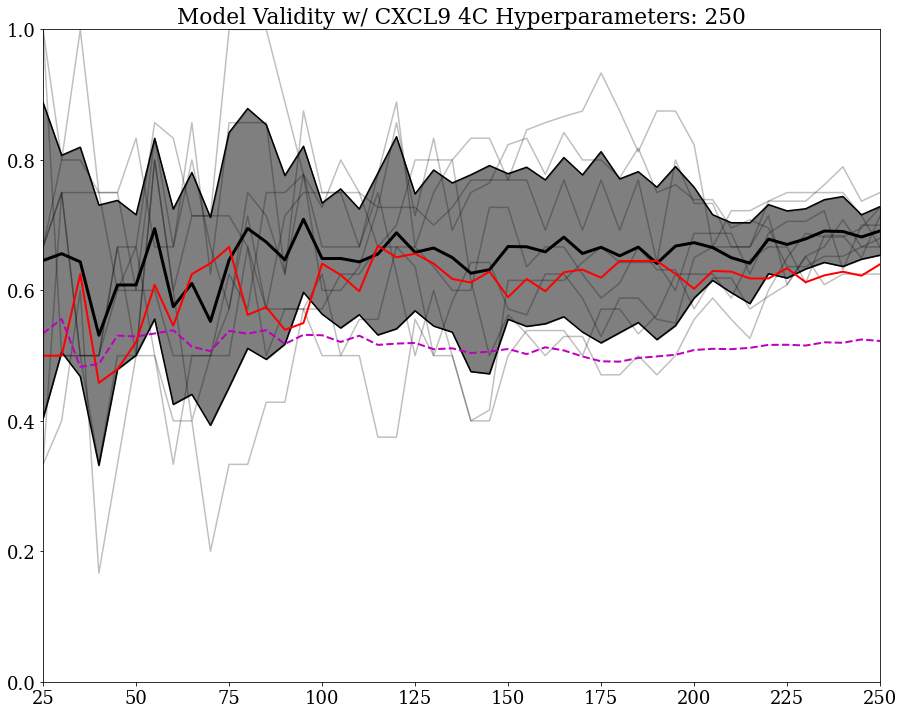

regular


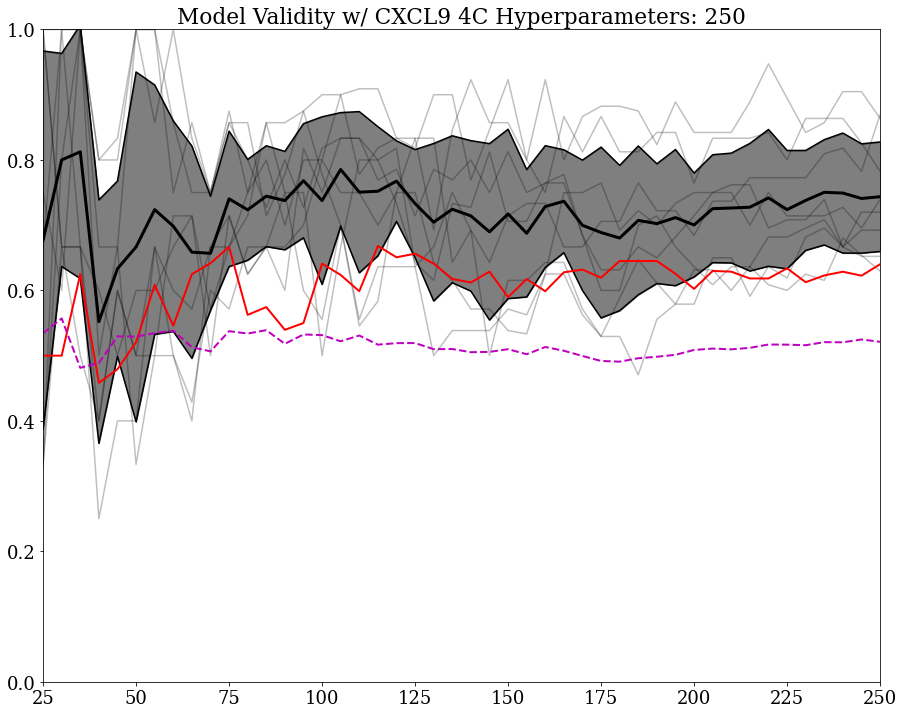

uniform


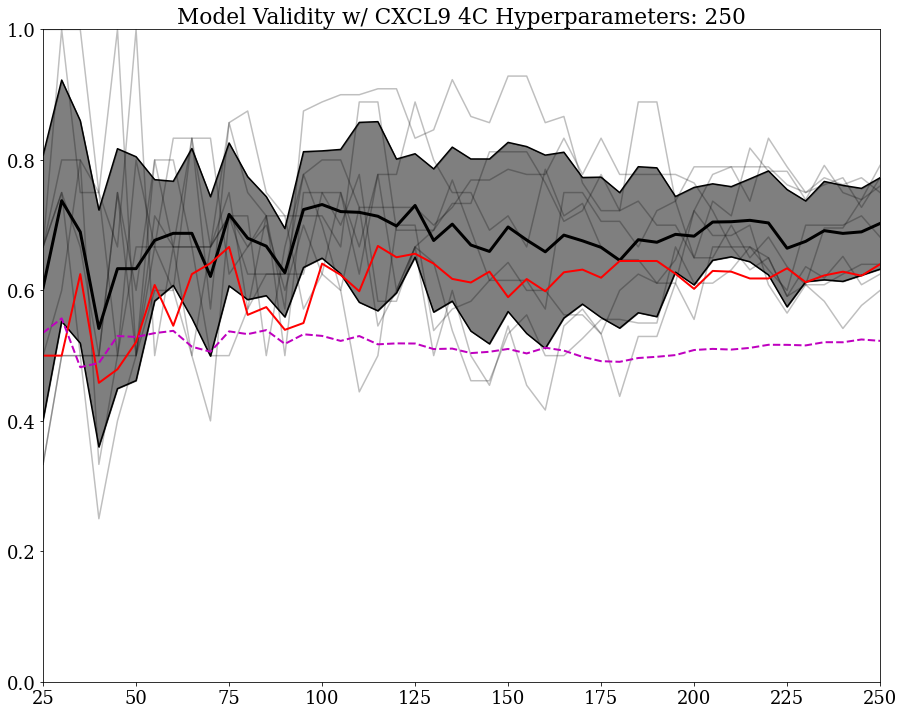

In [7]:
wavelet_vec_low = np.arange(1,101,10).astype(int)
wavelet_vec_high = np.arange(1000,3550,100).astype(int)
tolerance_vec = np.array([0.25])

delta = 10

alpha_vec = np.array([250])

for model in ['poisson','regular','uniform']:

    with open(data_path+'4C_data'+'.pkl', 'rb') as file:
        temp = pickle.load(file)
        df_4C = temp[0]
        df_x_raw = temp[1]
        df_x_kb = temp[2]
        df_x = temp[3]
        alpha = temp[4]
        filter_width = temp[5]
        window = temp[6]
        val = temp[7]
        N_files = temp[8]

    with open(data_path+'4C_params.pkl', 'rb') as file:
        temp = pickle.load(file)
        df_4C = temp[0]
        df_x = temp[1]
        df_hypervals_4C = temp[2]
        val = temp[3]

    with open(data_path+'ATACEM_'+model+'_params.pkl', 'rb') as file:
        temp = pickle.load(file)
        df_aapoly = temp[0]
        df_x = temp[1]
        df_hypervals_aapoly = temp[2]
        val = temp[3]

    with open(data_path+'ATACEM_'+model+'_pvals.pkl', 'rb') as file:
        temp = pickle.load(file)
        M = temp[0]
        df_pvals_0hr = temp[1]
        df_pvals_1hr = temp[2]
        df_metric_0hr = temp[3]
        df_metric_1hr = temp[4]
        df_mc_vec_0hr = temp[5]
        df_mc_vec_1hr = temp[6]
        alpha_vec = temp[7]
        metric_combined = temp[8]
        mc_metric_combined = temp[9]
        df_peaks_0hr_4C = temp[10]
        df_peaks_1hr_4C = temp[11]
        df_peaks_0hr_aapoly = temp[12]
        df_peaks_1hr_aapoly = temp[13]
        df_metric_4C_0hr = temp[14]
        df_metric_4C_1hr = temp[15]
        
    print(model)    
    
    for alpha in np.array([250]):
        for gt_name in ['CXCL9']:

            avg_total = np.zeros(len(alpha_vec))
            avg_4C = np.zeros(len(alpha_vec))
            avg_thresh_total = np.zeros(len(alpha_vec))


            name_vec =  ['IL6','CXCL9','CXCL10','IL15']

            metric_data = np.zeros([2*len(name_vec),len(alpha_vec)])
            metric_data_thresh = np.zeros([2*len(name_vec),len(alpha_vec)])
            metric_data_4C = np.zeros([len(name_vec),len(alpha_vec)])

            jdx = 0
            kdx = 0

            for gene_name in name_vec:

                temp_0hr = np.zeros(len(alpha_vec))
                temp_1hr = np.zeros(len(alpha_vec))
                temp_4C_0hr = np.zeros(len(alpha_vec))
                temp_4C_1hr = np.zeros(len(alpha_vec))
                thresh_0hr = np.zeros(len(alpha_vec))
                thresh_1hr = np.zeros(len(alpha_vec))

                idx = 0
                for a in alpha_vec:
                    temp_0hr[idx] = df_metric_0hr[gene_name,gt_name,a,alpha]
                    temp_1hr[idx] = df_metric_1hr[gene_name,gt_name,a,alpha]
                    thresh_0hr[idx] = np.mean(np.array(df_mc_vec_0hr[gene_name,gt_name,a,alpha]))
                    thresh_1hr[idx] = np.mean(np.array(df_mc_vec_1hr[gene_name,gt_name,a,alpha]))

                    if gene_name == 'IL6' or gene_name == 'CXCL9':
                        temp_4C_0hr[idx] = df_metric_4C_0hr[gene_name,a]
                        temp_4C_1hr[idx] = df_metric_4C_1hr[gene_name,a]

                    idx += 1

                metric_data[jdx,:] = temp_0hr
                metric_data_thresh[jdx,:] = thresh_0hr
                jdx += 1
                metric_data[jdx,:] = temp_1hr
                metric_data_thresh[jdx,:] = thresh_1hr
                jdx += 1

                if gene_name == 'IL6' or gene_name == 'CXCL9':
                    metric_data_4C[kdx,:] = temp_4C_0hr
                    kdx += 1
                    metric_data_4C[kdx,:] = temp_4C_1hr
                    kdx += 1
                    
                    
    plt.figure(figsize=(15,12))
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    plt.rc('font', **font)

    for i in range(np.shape(metric_data)[0]):
        plt.plot(alpha_vec,metric_data[i,:],'k-',alpha=0.25)

    plt.plot(alpha_vec,np.mean(metric_data,axis=0),'k-',linewidth=3)

    plt.plot(alpha_vec,np.mean(metric_data,axis=0)-np.std(metric_data,axis=0),'k-')
    plt.plot(alpha_vec,np.mean(metric_data,axis=0)+np.std(metric_data,axis=0),'k-')
    plt.fill_between(alpha_vec,np.mean(metric_data,axis=0)-np.std(metric_data,axis=0),
                     np.mean(metric_data,axis=0)+np.std(metric_data,axis=0),color='k',alpha=0.5)

    plt.plot(alpha_vec,np.mean(metric_data_4C,axis=0),'r-',linewidth=2)
    plt.plot(alpha_vec,np.mean(metric_data_thresh,axis=0),'m--',linewidth=2)


    plt.ylim([0,1])
    plt.xlim([alpha_vec[0],alpha_vec[-1]])

    plt.title("Model Validity w/ " + gt_name +" 4C Hyperparameters: " + str(alpha))

    plt.draw()
    plt.savefig(figure_path + r"model_validity_range_" + gt_name+ "_"+model+r".pdf", transparent=True)

    plt.show()